# **ECSE 551: Assignment 1**

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, probplot
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_diabetes, load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

plt.rcParams.update({"font.size": 8})

## **Task 1**
### **1.1 Regression**

#### 1.1.1 Data loading

In [2]:
diabetes = load_diabetes()
X_reg = diabetes.data 
y_reg = diabetes.target
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.3, random_state=42)
df_reg = pd.DataFrame(X_reg, columns=diabetes.feature_names)
df_reg['target'] = y_reg
print(f"Features: {diabetes.feature_names}")

Features: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']


#### 1.1.2 Data Cleaning and Statistical analysis

We first examine if any of the values are missing. As can be seen in the cell below, we observe that there is no missing data.

In [3]:
# verify integrity of data
display(df_reg.isnull().any())

age       False
sex       False
bmi       False
bp        False
s1        False
s2        False
s3        False
s4        False
s5        False
s6        False
target    False
dtype: bool

We now take a look at the descriptive statistics of the dataset. We see that the data has already been centered as the mean of all the predictors is zero. The scaling was done based the entire dataset. To avoid data leakage, we will later rescale the data based on the training data alone.

In [4]:
# descriptive statistics
print("Descriptive Statistics - Scaled Full Dataset")
display(df_reg.describe().round(2))

Descriptive Statistics - Scaled Full Dataset


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,442.00,442.00,442.00,442.00,442.00,442.00,442.00,442.00,442.00,442.00,442.00
mean,-0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,152.13
std,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,77.09
min,-0.11,-0.04,-0.09,-0.11,-0.13,-0.12,-0.10,-0.08,-0.13,-0.14,25.00
25%,-0.04,-0.04,-0.03,-0.04,-0.03,-0.03,-0.04,-0.04,-0.03,-0.03,87.00
50%,0.01,-0.04,-0.01,-0.01,-0.00,-0.00,-0.01,-0.00,-0.00,-0.00,140.50
75%,0.04,0.05,0.03,0.04,0.03,0.03,0.03,0.03,0.03,0.03,211.50
max,0.11,0.05,0.17,0.13,0.15,0.20,0.18,0.19,0.13,0.14,346.00


We now want to do statistical profiling and understand if our predictors are normaly distributed. We show below the skewness and kurtosis of each predictors. The histogram and Q-Q plot of each predictor is also shown for visualization purposes.

,skewness,kurtosis
age,-0.230596,-0.677199
sex,0.126952,-1.983883
bmi,0.596117,0.080478
bp,0.289671,-0.540333
s1,0.376824,0.216777
s2,0.435109,0.581056
s3,0.796540,0.956896
s4,0.732876,0.425846
s5,0.290763,-0.146396
s6,0.207210,0.220701


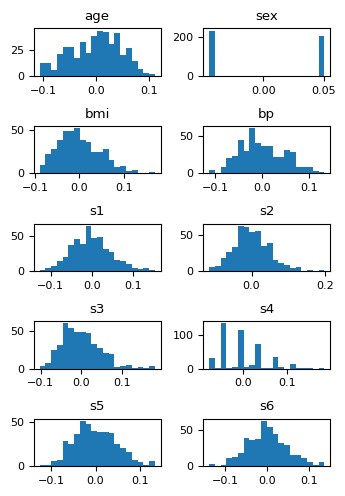

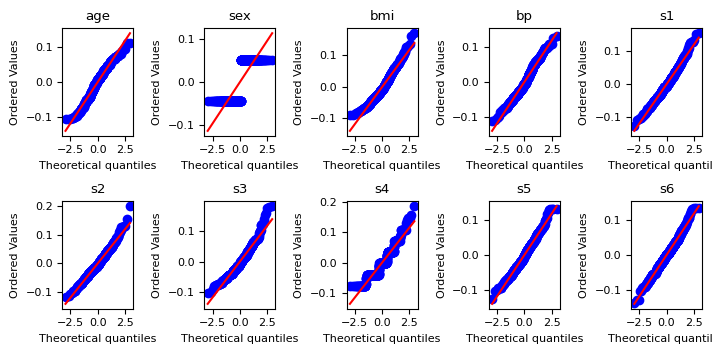

In [5]:
# kurtosis and skewness
display(pd.DataFrame(
    {"skewness": skew(df_reg, axis=0), "kurtosis": kurtosis(df_reg, axis=0)},
    index=df_reg.columns,
))

# histogram of each of the features
fig, axs = plt.subplots(5, 2, figsize=(3.5, 5))
for i, ax in enumerate(axs.ravel()):
    ax.hist(X_reg[:, i], bins=20)
    ax.set_title(diabetes.feature_names[i])

fig.tight_layout()
plt.show()


fig, axs = plt.subplots(2, 5, figsize=(7.16, 7.16/2))

for i, ax in enumerate(axs.ravel()):
    
    # Q-Q plot
    probplot(X_reg[:, i], dist="norm", plot=ax)
    ax.set_title(f"{diabetes.feature_names[i]}")

fig.tight_layout()
plt.show()

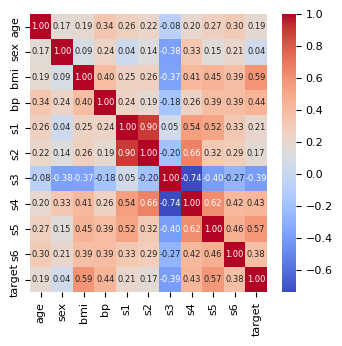

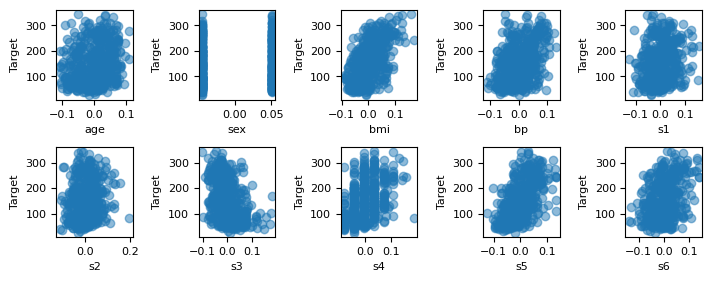

In [6]:
# correlation matrix
fig, ax = plt.subplots(figsize=(3.5, 3.5))
sns.heatmap(df_reg.corr(), annot=True, fmt=".2f", cmap="coolwarm", ax=ax, annot_kws={"size": 6})
fig.tight_layout()
plt.show()

# scatter plot of each feature against the target
fig, axs = plt.subplots(2, 5, figsize=(7.16, 7.16 / 2.5))
for i, ax in enumerate(axs.ravel()):
    ax.scatter(X_reg[:, i], y_reg, alpha=0.5)
    ax.set_xlabel(diabetes.feature_names[i])
    ax.set_ylabel("Target")

fig.tight_layout()
plt.show()


We now want to remove any outliers that could make learning more difficult. To do so we look at the box plot.

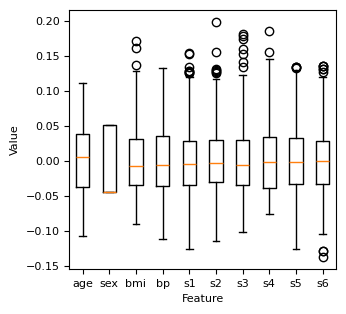

In [7]:
# boxplot of each of the features
plt.figure(figsize=(3.5, 3.5/1.1))
plt.boxplot(X_reg, vert=True, tick_labels=diabetes.feature_names)
plt.xlabel("Feature")
plt.ylabel("Value")
plt.tight_layout()
plt.show()

The boxplot reveals that there are some outliers. We can use the Interquartile Range (IQR) to remove outliers. We make sure to only remove outliers in the training dataset to avoid data leakage. The IQR is also evaluated with respect to the training data.

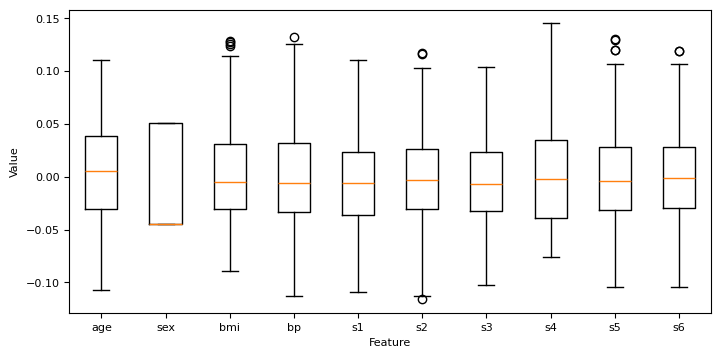

In [8]:
# calculate IQR based on training data
Q1 = np.percentile(X_reg_train, 25, axis=0)
Q3 = np.percentile(X_reg_train, 75, axis=0)
IQR = Q3 - Q1

# define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# identify outliers (remove sample if ANY feature is outside bounds)
outlier_mask = np.any((X_reg_train < lower_bound) | (X_reg_train > upper_bound), axis=1)

# remove outliers from training data
X_reg_train_clean = X_reg_train[~outlier_mask]
y_reg_train = y_reg_train[~outlier_mask]

# boxplot of each the predictors with outliers removed
plt.figure(figsize=(7.25, 7.25/2))
plt.boxplot(X_reg_train_clean, vert=True, tick_labels=diabetes.feature_names)
plt.xlabel("Feature")
plt.ylabel("Value")
plt.tight_layout()
plt.show()

Finally, we rescale the predictors based on the training data only to avoid data leakage.

In [9]:
scaler_X = StandardScaler()
X_reg_train_scaled = scaler_X.fit_transform(X_reg_train_clean)
X_reg_test_scaled = scaler_X.transform(X_reg_test)

### **1.2 Classification**

#### 1.2.1 Data loading

In [10]:
digits = load_digits()
X = digits.data
y = digits.target

# Check output range and type (entries are np.int64):
print("All outputs are integers in [0, 9]:")
print(np.all([((type(y[i]) == np.int64) & (y[i] > -1) & (y[i] < 10)) for i in range(0,len(y))]))

# Check input range and type (entries are np.float64):
print("All inputs are vectors of integers in [0, 16]:")
print(np.all([((np.max(abs(X[i,j] - np.round(X[i,j]))) == 0) & (type(X[i,j]) == np.float64) & (X[i,j] > -1) & (X[i,j] < 17)) for i in range(0, np.size(X,0)) for j in range(0, np.size(X,1))]))

# Check for duplicate inputs:
print("All inputs are unique:")
unique_X = np.unique(X, axis=0)
print(np.size(X,0) == np.size(unique_X,0))

All outputs are integers in [0, 9]:
True
All inputs are vectors of integers in [0, 16]:
True
All inputs are unique:
True


#### 1.2.2 Statistical Analysis

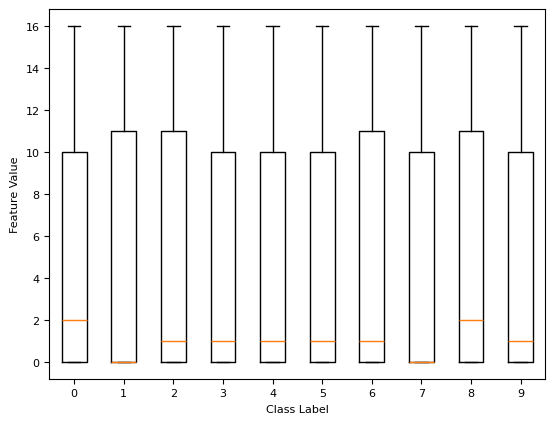

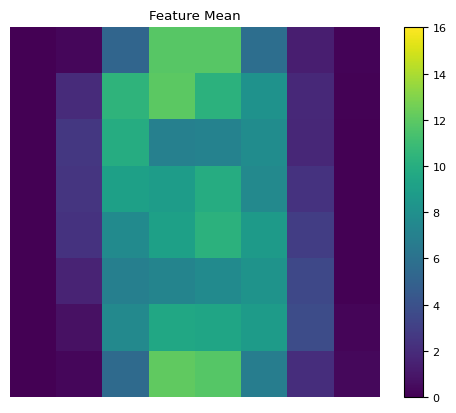

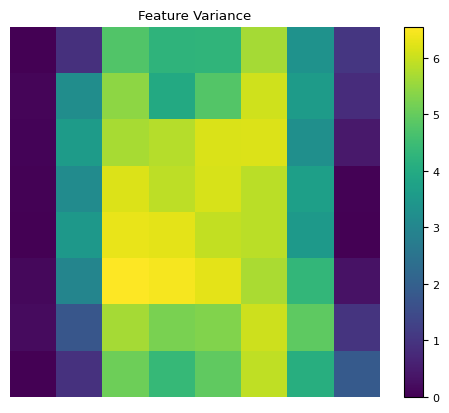

Features with min variance:
(array([ 0, 32, 39]),)
Features with max variance:
(array([42]),)


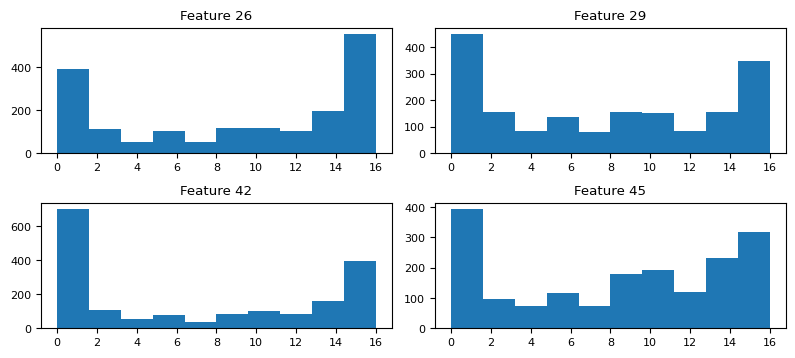

/home/pierre/projects/machine-learning/ECSE_551_A1/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3023: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/pierre/projects/machine-learning/ECSE_551_A1/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3024: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


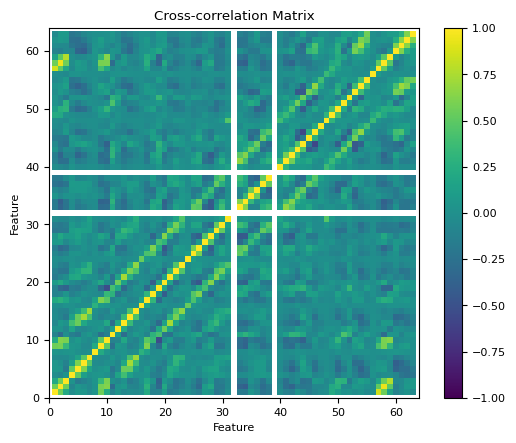

In [11]:
# Now, we perform brief statistical analysis on the data

# Box plots of feature values (all) for each class
sorted_X = [np.ravel(X[y == i,:]) for i in range(0,10)]
plt.boxplot(sorted_X, tick_labels=[str(i) for i in range(0,10)])
plt.xlabel("Class Label")
plt.ylabel("Feature Value")
plt.show()

# Mean for each feature (shown as 8x8 image)
plt.imshow(np.reshape(np.mean(X, axis=0), (8,8)), vmin=0, vmax=16)
plt.axis('off')
plt.colorbar()
plt.title("Feature Mean")
plt.show()

# Variance for each feature (shown as 8x8 image)
plt.imshow(np.reshape(np.std(X, axis=0), (8,8)))
plt.axis('off')
plt.colorbar()
plt.title("Feature Variance")
plt.show()

print("Features with min variance:")
print(np.where(np.std(X, axis=0) == np.min(np.std(X, axis=0))))

print("Features with max variance:")
print(np.where(np.std(X, axis=0) == np.max(np.std(X, axis=0))))

# Histogram for the "center" features
fig, axs = plt.subplots(2, 2, figsize=(8, 7.25/2))
axs[0,0].hist(X[:,26])
axs[0,0].set_title("Feature 26")
axs[0,1].hist(X[:,29])
axs[0,1].set_title("Feature 29")
axs[1,0].hist(X[:,42])
axs[1,0].set_title("Feature 42")
axs[1,1].hist(X[:,45])
axs[1,1].set_title("Feature 45")
fig.tight_layout()
plt.show()

# Correlation coefficient (missing pixels have a standard deviation of 0)
corr = np.corrcoef(X.T)
plt.imshow(corr, vmin=-1, vmax=1)
plt.colorbar()
plt.title("Cross-correlation Matrix")
plt.xlim([0, 64])
plt.ylim([0, 64])
plt.xlabel("Feature")
plt.ylabel("Feature")
plt.show()



## **Task 2**

### **2.1 Regression**

#### 2.1.1 Lasso Regression

In [12]:
class LassoRegression():
    def __init__(self, learning_rate, iterations, penalty):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.penalty = penalty
        self.weights = None 
        self.X_train = None  # training data
        self.y_train = None  # training labels
        self.training_loss = None  # training loss over iterations

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.weights = np.zeros(X.shape[1] + 1) # add one for bias term
        self.training_loss = [] # reset training loss

        for i in range(self.iterations):
            self.update_weights()
            
            # compute training loss
            error = self.predict(X) - y
            loss = (
                (1 / (2 * X.shape[0])) * np.linalg.norm(error, 2) ** 2 + 
                self.penalty * np.linalg.norm(self.weights[1:], 1)
                ) # exclude bias term from penalty
            self.training_loss.append(loss) # store training loss for given iteration
        return self
    
    def update_weights(self):
        m = self.X_train.shape[0]
        X_aug = np.hstack((np.ones((m, 1)), self.X_train)) # augment with bias term
        weights_gradient = 1 / m * (X_aug.T @ (X_aug @ self.weights - self.y_train))
        self.weights -= self.learning_rate * weights_gradient
        # apply soft-thresholding for L1 penalty (excluding bias term)
        self.weights[1:] = LassoRegression.soft_threshold(
            self.weights[1:], self.learning_rate * self.penalty
            ) 
 
    def predict(self, X):
        if self.weights is None:
            raise ValueError("Model is not trained yet.")
        else:
            return X @ self.weights[1:] + self.weights[0]
        
    @staticmethod
    def soft_threshold(z, alpha):
        return np.sign(z) * np.maximum(np.abs(z) - alpha, 0)

#### 2.1.2 ElasticNet

In [13]:
class ElasticNetRegression():
    def __init__(self, learning_rate, iterations, penalty, l1_ratio):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.lambda1 = penalty * l1_ratio
        self.lambda2 = penalty * (1 - l1_ratio)
        self.weights = None 
        self.X_train = None  # training data
        self.y_train = None  # training labels
        self.training_loss = None  # training loss over iterations
  
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.weights = np.zeros(X.shape[1] + 1) # add one for bias term
        self.training_loss = []

        for i in range(self.iterations):
            self.update_weights()

            # compute training loss
            error = self.predict(X) - y
            loss = (
                (1 / (2 * X.shape[0])) * np.linalg.norm(error, 2) ** 2 +
                self.lambda1 * np.linalg.norm(self.weights[1:], 1) +
                (self.lambda2 / 2) * np.linalg.norm(self.weights[1:], 2) ** 2
            )
            self.training_loss.append(loss)
            
        return self
    
    def update_weights(self):
        m = self.X_train.shape[0]
        X_aug = np.hstack((np.ones((m, 1)), self.X_train)) # augment with bias term
        weights_gradient = 1 / m * (X_aug.T @ (X_aug @ self.weights - self.y_train)) + self.lambda2 * np.hstack((0, self.weights[1:]))
        self.weights -= self.learning_rate * weights_gradient
        # apply soft-thresholding for L1 penalty (excluding bias term)
        self.weights[1:] = LassoRegression.soft_threshold(
            self.weights[1:], self.learning_rate * self.lambda1
            ) 
 
    def predict(self, X):
        if self.weights is None:
            raise ValueError("Model is not trained yet.")
        else:
            return X @ self.weights[1:] + self.weights[0]
        
    @staticmethod
    def soft_threshold(z, alpha):
        return np.sign(z) * np.maximum(np.abs(z) - alpha, 0)

#### 2.1.3 Analysis

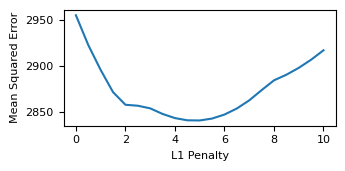

Optimal Lasso penalty: 5.00, MSE: 2840.5836


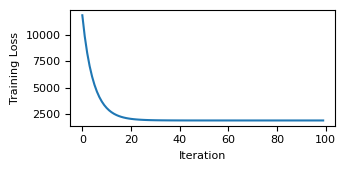

Lasso Regression MSE: 2840.58
The lasso regression weights are: 
 [152.06   0.    -4.9   22.92  14.99  -0.    -0.   -12.34   0.    14.5
   0.  ]


In [14]:
# MSE vs L1 penalty figure for lasso regression
mse = []
penalties = np.linspace(0, 10, 21)
for penalty in penalties:
    lasso = LassoRegression(learning_rate=0.1, iterations=100, penalty=penalty).fit(X_reg_train_scaled, y_reg_train)
    ypred = lasso.predict(X_reg_test_scaled)
    mse.append(mean_squared_error(y_reg_test, ypred))
plt.figure(figsize=(3.5, 3.5/2))
plt.plot(penalties, mse)
plt.xlabel("L1 Penalty")
plt.ylabel("Mean Squared Error")
plt.tight_layout()
plt.show()

# best penalty for Lasso based on MSE curve
min_idx = int(np.argmin(mse))
best_penalty = penalties[min_idx]
best_mse = mse[min_idx]
print(f"Optimal Lasso penalty: {best_penalty:.2f}, MSE: {best_mse:.4f}")


# lasso regression
lasso_regression = LassoRegression(learning_rate=0.1, iterations=100, penalty=best_penalty).fit(X_reg_train_scaled, y_reg_train)
ypred_lasso = lasso_regression.predict(X_reg_test_scaled)

plt.figure(figsize=(3.5, 3.5/2))
plt.plot(lasso_regression.training_loss)
plt.xlabel("Iteration")
plt.ylabel("Training Loss")
plt.tight_layout()
plt.show()

mse_lasso = mean_squared_error(y_reg_test, ypred_lasso)
print(f"Lasso Regression MSE: {mse_lasso:.2f}")
print('The lasso regression weights are: \n', np.array2string(lasso_regression.weights, precision=2, suppress_small=True))

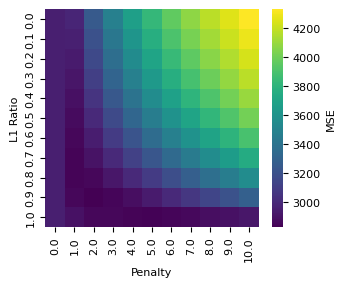

Optimal ElasticNet parameters: penalty: 2.00, l1_ratio: 0.90, MSE: 2828.9304


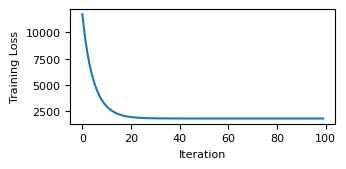

ElasticNet Regression MSE: 2828.93
The ElasticNet regression weights are: 
 [152.06   0.47  -7.77  20.55  15.62  -0.15  -2.16 -12.05   3.97  13.56
   1.76]


In [15]:
# MSE heatmap for ElasticNet regression varying penalty and l1_ratio
penalties = np.linspace(0, 10, 11)
l1_ratios = np.linspace(0, 1, 11)
mse_grid = np.zeros((len(l1_ratios), len(penalties)))

for i, l1_ratio in enumerate(l1_ratios):
    for j, penalty in enumerate(penalties):
        enet = ElasticNetRegression(learning_rate=0.1, iterations=100, penalty=penalty, l1_ratio=l1_ratio).fit(X_reg_train_scaled, y_reg_train)
        ypred = enet.predict(X_reg_test_scaled)
        mse_grid[i, j] = mean_squared_error(y_reg_test, ypred)

plt.figure(figsize=(3.5, 3.5/1.2))
step = 2
sns.heatmap(
    mse_grid,
    xticklabels=np.round(penalties, 2),
    yticklabels=np.round(l1_ratios, 2),
    cmap="viridis",
    cbar_kws={"label": "MSE"},
)
plt.xlabel("Penalty")
plt.ylabel("L1 Ratio")
plt.tight_layout()
plt.show()

# best penalty and l1_ratio pair based on MSE grid
min_idx = np.unravel_index(np.argmin(mse_grid), mse_grid.shape)
best_l1_ratio = l1_ratios[min_idx[0]]
best_penalty = penalties[min_idx[1]]
best_mse = mse_grid[min_idx]
print(f"Optimal ElasticNet parameters: penalty: {best_penalty:.2f}, l1_ratio: {best_l1_ratio:.2f}, MSE: {best_mse:.4f}")

# enet regression
enet_regression = ElasticNetRegression(learning_rate=0.1, iterations=100, penalty=best_penalty, l1_ratio=best_l1_ratio).fit(X_reg_train_scaled, y_reg_train)
ypred_enet = enet_regression.predict(X_reg_test_scaled)

plt.figure(figsize=(3.5, 3.5/2))
plt.plot(enet_regression.training_loss)
plt.xlabel("Iteration")
plt.ylabel("Training Loss")
plt.tight_layout()
plt.show()

mse_enet = mean_squared_error(y_reg_test, ypred_enet)
print(f"ElasticNet Regression MSE: {mse_enet:.2f}")
print('The ElasticNet regression weights are: \n', np.array2string(enet_regression.weights, precision=2, suppress_small=True))

In [16]:
# linear regression from sklearn
linear_regression = LinearRegression().fit(X_reg_train_scaled, y_reg_train)
ypred_lr = linear_regression.predict(X_reg_test_scaled)
mse_lr = mean_squared_error(y_reg_test, ypred_lr)
print(f"Linear Regression MSE: {mse_lr:.2f}")
print('The linear regression weights are: \n', np.array2string(np.hstack((linear_regression.intercept_, linear_regression.coef_)), precision=2, suppress_small=True))

Linear Regression MSE: 2962.44
The linear regression weights are: 
 [152.06   1.89 -13.87  23.13  20.37 -17.28   5.54  -8.91   9.49  20.45
   0.19]


### **2.2 Classification**

#### 2.2.1 Multiclass SVM

In [17]:
# Multiclass SVM class

class MulticlassSVM:
    def __init__(self, learning_rate, lambda_param, n_iters):
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.Nfeat = 64
        self.Nclass = 10
        self.w = np.zeros((self.Nfeat+1, self.Nclass)) # All SVM parameters, each column corresponds to one digit, w[0] is the bias

    def fit(self, X, y):
        ytilde = np.zeros(np.shape(y)) # stores transformed inputs, (N,) array
        Linf_grad = np.zeros((self.Nclass,)) # stores L\infty norm of gradient for each class when gradient descent terminates

        for digit in range(0,self.Nclass):
            ytilde[y==digit] = 1.0
            ytilde[y!=digit] = -1.0

            # gradient descent
            w = np.ones((np.size(X,1)+1,))
            grad = np.zeros((np.size(X,1)+1,))

            for i in range(0, self.n_iters):
                # compute gradient
                mask = (ytilde * (X @ w[1:self.Nfeat+1] + w[0])) < 1
                grad[1:self.Nfeat+1] = w[1:self.Nfeat+1] - self.lambda_param * np.sum(X[mask,:] * ytilde[mask,None], axis=0)
                grad[0] = - self.lambda_param * np.sum(ytilde[mask])

                # gradient step
                w = w - self.learning_rate * grad
            
            self.w[:, digit] = np.ravel(w) / np.sqrt(np.sum(w[1:self.Nfeat+1] ** 2)) # normalize and update weights
            Linf_grad[digit] = np.max(np.abs(grad))
        
        self.Linf_grad = Linf_grad

    def predict(self, X):
        if len(np.shape(X)) == 1:
            return np.argmax(X @ self.w[1:self.Nfeat+1,:] + self.w[0,:])
        elif len(np.shape(X)) == 2:
            return np.argmax(X @ self.w[1:self.Nfeat+1,:] + self.w[0,:][None,:], axis=1)


In [18]:
# Training and testing the SVM

# Training and testing sets
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=42)
Xtrain = Xtrain / 16 # We normalize
Xtest = Xtest / 16

In [19]:
# We perform cross validation to select the best \lambda and learning rate

# We re-split the testing data set for these purposes
Xtrain1, Xtrain2, ytrain1, ytrain2 = train_test_split(Xtrain, ytrain, test_size=0.3, random_state=42)

lambda_val = np.linspace(0,3.0, 15)
learning_rate =  2.0 ** (-np.arange(2,15))
N = 20000 # fixed number of iterations

ER1 = np.zeros((len(lambda_val), len(learning_rate)))

total_iterations = len(lambda_val) * len(learning_rate)
current_count = 0

for i in range(0, len(lambda_val)):
    for j in range(0, len(learning_rate)):
        current_count += 1
        sys.stdout.write(f"\rFitting model {current_count}/{total_iterations} | Lambda: {lambda_val[i]:.2f} | LR: {learning_rate[j]:.5f}")
        sys.stdout.flush()
        my_SVM = MulticlassSVM(learning_rate[j], lambda_val[i], N)
        my_SVM.fit(Xtrain1, ytrain1)
        ER1[i,j] = np.sum(my_SVM.predict(Xtrain2) != ytrain2) / np.size(ytrain2)

# Select best parameters
i, j = np.unravel_index(np.argmin(ER1), np.shape(ER1))
print("\nlambda:")
print(lambda_val[i])
print("learning rate:")
print(learning_rate[j])
print("Minimum Error Rate")
print(ER1[i,j])
        

Fitting model 1/195 | Lambda: 0.00 | LR: 0.25000

/tmp/ipykernel_2445876/3383114765.py:33: RuntimeWarning: divide by zero encountered in divide
  self.w[:, digit] = np.ravel(w) / np.sqrt(np.sum(w[1:self.Nfeat+1] ** 2)) # normalize and update weights


Fitting model 2/195 | Lambda: 0.00 | LR: 0.12500

/tmp/ipykernel_2445876/3383114765.py:42: RuntimeWarning: invalid value encountered in matmul
  return np.argmax(X @ self.w[1:self.Nfeat+1,:] + self.w[0,:][None,:], axis=1)


Fitting model 195/195 | Lambda: 3.00 | LR: 0.00006
lambda:
1.5
learning rate:
0.00048828125
Minimum Error Rate
0.03968253968253968


In [20]:
# MLP class

# Assume only one hidden layer??

class MLP:
    def __init__(self, input_sz, hidden_sz, output_sz, learning_rate):
        self.input_sz = input_sz
        self.hidden_sz = hidden_sz
        self.output_s = output_sz
        self.learning_rate = learning_rate
        self.Nclass = 10
        self.Nfeat = 64

        rng = np.random.default_rng(seed=42)

        self.W1 = rng.random((hidden_sz, input_sz)) / input_sz
        self.B1 = rng.random((hidden_sz,)) / input_sz
        self.W2 = rng.random((output_sz, hidden_sz)) / hidden_sz
        self.B2 = rng.random((output_sz,)) / hidden_sz
    
    def relu(self, z):
        f = np.zeros(np.shape(z))
        mask = z > 0
        f[mask] = z[mask]
        return f
    
    def relu_derivative(self, z):
        df = np.zeros(np.shape(z))
        df[z > 0] = 1.0
        return df
    
    def softmax(self, z):
        x = np.exp(z)
        if len(np.shape(z)) == 1:
            return x / np.sum(x)
        elif len(np.shape(z)) == 2: # for matrices, softmax is computed row-wise
            return x / np.sum(x, axis=1)[:,None]
    
    def mult_softmax_Jacobian(self, z, x): # multiplication of x by softmax Jacobian at z
        s = self.softmax(z)
        return -np.dot(s,x) * s + s * x # softmax has symmetric jacobian

    def fit(self, X, y, epochs):
        Ntrain = np.size(X,0)

        W1 = self.W1
        B1 = self.B1
        W2 = self.W2
        B2 = self.B2

        # pre-allocation
        Loss = np.zeros((epochs,))
        gradW1 = np.zeros(np.shape(W1))
        gradB1 = np.zeros(np.shape(B1))
        gradW2 = np.zeros(np.shape(W2))
        gradB2 = np.zeros(np.shape(B2))

        for i in range(0, epochs):
            # Compute grad by looping over all training samples
            gradW1[:] = 0.0
            gradB1[:] = 0.0
            gradW2[:] = 0.0
            gradB2[:] = 0.0

            for itrain in range(0, Ntrain):
                # forward pass
                x1 = W1 @ X[itrain,:] + B1  # x1 = W1 @ X + B1
                x2 = self.relu(x1)          # x2 = ReLu(x1)
                x3 = W2 @ x2 + B2           # x3 = W2 @ x2 + B2
                x4 = self.softmax(x3)       # x4 = softmax(x3)
                Loss[i] += 0.5 * np.sum((x4 - ytrain[itrain]) ** 2)

                # backward pass
                dL_dx3 = self.mult_softmax_Jacobian(x3, x4 - y[itrain,:]) # \partial L / \partial x3
                gradW2 += np.outer(dL_dx3, x2) # shortcut to reshape gradient as a matrix
                gradB2 += dL_dx3 # since Jacobian \partial x3 / \partial B1 is identity
                dL_dx1 = (dL_dx3 @ W2) * self.relu_derivative(x2) # since Jacobian \partial x2 / \partial x1 is diagonal
                gradW1 += np.outer(dL_dx1, X[itrain, :])
                gradB1 += dL_dx1
            
            # use gradient descent to update param
            W1 -= self.learning_rate * gradW1
            B1 -= self.learning_rate * gradB1
            W2 -= self.learning_rate * gradW2
            B2 -= self.learning_rate * gradB2
        
        self.W1 = W1
        self.B1 = B1
        self.W2 = W2
        self.B2 = B2
        self.Loss = Loss
    
    def predict_proba(self, X):
        if len(np.shape(X)) == 1:
            return self.softmax(self.W2 @ self.relu(self.W1 @ X + self.B1) + self.B2)
        elif len(np.shape(X)) == 2:
            return self.softmax((self.W2 @ self.relu(self.W1 @ X.T + self.B1[:,None]) + self.B2[:,None]).T)

    def predict(self, X):
        if len(np.shape(X)) == 1:
            return np.argmax(self.predict_proba(X))
        elif len(np.shape(X)) == 2:
            return np.argmax(self.predict_proba(X), axis=1)

In [21]:
# Testing MLP

# Training and testing sets

# We split and normalize
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=42)
Xtrain = Xtrain / 16
Xtest = Xtest / 16

# We encode classes using binary vectors (could have used sklearn, but this one is easy to do)
ytrain_enc = np.zeros((len(ytrain), 10))
index = range(0,len(ytrain))
ytrain_enc[index, ytrain[index]] = 1.0

In [22]:
# We perform cross-validation to select the best hidden layer size and the learning rate
Xtrain1, Xtrain2, ytrain1, ytrain2 = train_test_split(Xtrain, ytrain, test_size=0.3, random_state=42)
ytrain_enc1 = np.zeros((len(ytrain1), 10))
index = range(0,len(ytrain1))
ytrain_enc1[index, ytrain1[index]] = 1.0

learning_rate = np.array([0.1, 0.01, 0.001, 0.0001])
Nhidden = np.array([2, 4, 8, 16, 32, 64, 128])

epochs = 1100 # fixed number of iterations

ER2 = np.zeros((len(Nhidden), len(learning_rate)))

total_iterations = len(Nhidden) * len(learning_rate)
current_count = 0

for i in range(0, len(Nhidden)):
    for j in range(0, len(learning_rate)):
        current_count += 1
        sys.stdout.write(f"\rFitting model {current_count}/{total_iterations} | Hidden layer size: {Nhidden[i]:.2f} | LR: {learning_rate[j]:.5f}")
        sys.stdout.flush()
        my_MLP = MLP(64, Nhidden[i], 10, learning_rate[j])
        my_MLP.fit(Xtrain1, ytrain_enc1, epochs)
        ER2[i,j] = np.sum(my_MLP.predict(Xtrain2) != ytrain2) / np.size(ytrain2)

# Select best combination:
i, j = np.unravel_index(np.argmin(ER2), np.shape(ER2))
print("\nNhidden:")
print(Nhidden[i])
print("learning_rate:")
print(learning_rate[j])
print("Minimum Error Rate:")
print(ER2[i,j])


Fitting model 9/28 | Hidden layer size: 8.00 | LR: 0.10000

/tmp/ipykernel_2445876/2225951789.py:33: RuntimeWarning: overflow encountered in exp
  x = np.exp(z)
/tmp/ipykernel_2445876/2225951789.py:35: RuntimeWarning: invalid value encountered in divide
  return x / np.sum(x)


Fitting model 28/28 | Hidden layer size: 128.00 | LR: 0.00010
Nhidden:
32
learning_rate:
0.001
Minimum Error Rate:
0.03968253968253968


In [23]:
# Evaluate impact of number of epochs
epochs = 2 ** np.arange(1, 14)
ERj = np.zeros(np.shape(epochs))

for i in range(0, len(epochs)):
    my_MLP = MLP(64, 32, 10, 0.001)
    my_MLP.fit(Xtrain, ytrain_enc, epochs[i])
    ERj[i] = np.sum(my_MLP.predict(Xtrain2) != ytrain2) / np.size(ytrain2)

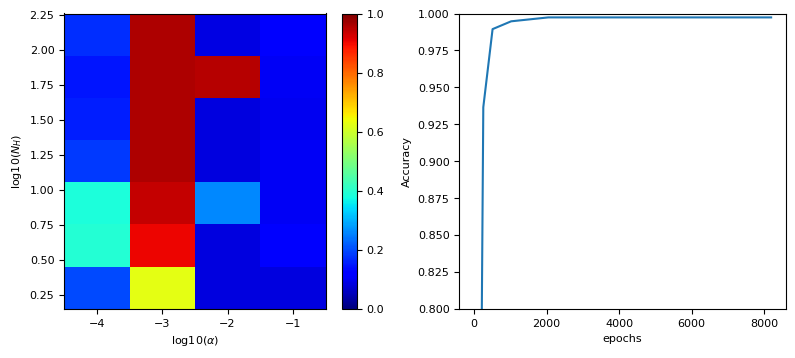

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(8, 7.25/2))

map=axs[0].pcolormesh(np.log10(learning_rate), np.log10(Nhidden), (1-ER2), shading='nearest', cmap='jet', vmin=0, vmax=1)
axs[0].set_xlabel(r"log10($\alpha$)")
axs[0].set_ylabel(r"log10($N_{H}$)")
fig.colorbar(map, ax=axs[0], orientation='vertical')

axs[1].plot(epochs, 1-ERj)
axs[1].set_ylabel("Accuracy")
axs[1].set_xlabel("epochs")
axs[1].set_ylim([0.8, 1])

fig.tight_layout()
plt.show()

In [25]:
# Final training
my_MLP = MLP(64, 32, 10, 0.001)
my_MLP.fit(Xtrain, ytrain_enc, 4000)

In [26]:
# Test model
mlp_preds = my_MLP.predict(Xtest)
print("Error Rate")
print(np.sum(ytest != mlp_preds) / np.size(ytest))

Error Rate
0.027777777777777776


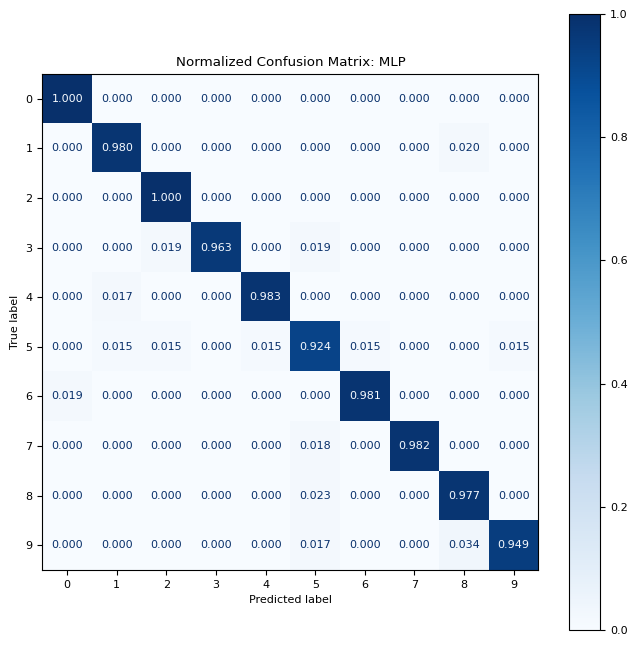

In [27]:
cm = confusion_matrix(ytest, mlp_preds, normalize='true')
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(ytest))
disp.plot(cmap='Blues', ax=ax, values_format='.3f')
plt.title("Normalized Confusion Matrix: MLP")
plt.grid(False)
plt.show()

#### 2.2.2 MLP

#### 2.2.3 Random Forest Classifier

In [28]:
# Testing RF Classifier

# Training and testing sets

# We split and normalize with the same test setup as before
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=42)
Xtrain = Xtrain / 16
Xtest = Xtest / 16

In [29]:
# We perform cross validation to select the best \lambda and learning rate

# We re-split the testing data set for these purposes
Xtrain1, Xtrain2, ytrain1, ytrain2 = train_test_split(Xtrain, ytrain, test_size=0.3, random_state=42)

n_estimators_range = np.array([10, 20, 40, 80, 160, 320, 640])
max_depth_range = np.array([None, 5, 10, 15, 20])

ER_RF = np.zeros((len(n_estimators_range), len(max_depth_range)))

total_iterations = len(n_estimators_range) * len(max_depth_range)
current_count = 0

for i in range(len(n_estimators_range)):
    for j in range(len(max_depth_range)):
        current_count += 1
        if max_depth_range[j] is None:
            sys.stdout.write(f"\rFitting model {current_count}/{total_iterations} | Num estimators: {n_estimators_range[i]:.2f} | Max depth: None")
        else:
            sys.stdout.write(f"\rFitting model {current_count}/{total_iterations} | Num estimators: {n_estimators_range[i]:.2f} | Max depth: {max_depth_range[j]:.2f}")

        sys.stdout.flush()
        rf = RandomForestClassifier(
            n_estimators=n_estimators_range[i],
            max_depth=max_depth_range[j],
            random_state=42,
            n_jobs=-1
        )

        rf.fit(Xtrain1, ytrain1)

        preds = rf.predict(Xtrain2)
        ER_RF[i,j] = np.sum(preds != ytrain2) / np.size(ytrain2)

# Select best parameters
i, j = np.unravel_index(np.argmin(ER_RF), np.shape(ER_RF))
print("\nn_estimators:")
print(n_estimators_range[i])
print("max_depth:")
print(max_depth_range[j])
print("Minimum Error Rate:")
print(ER_RF[i,j])


Fitting model 35/35 | Num estimators: 640.00 | Max depth: 20.00
n_estimators:
320
max_depth:
None
Minimum Error Rate:
0.031746031746031744


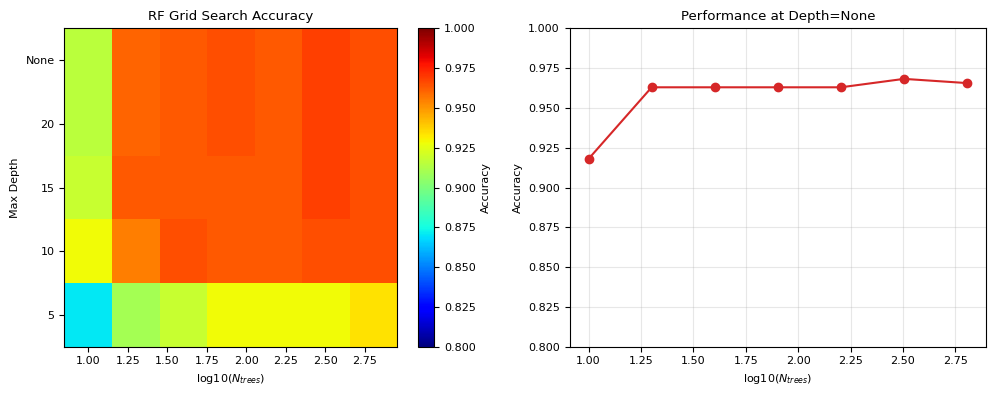

In [30]:
# Treat depth of None as a deep value (ex. 25)
depth_numeric = np.array([d if d is not None else 25 for d in max_depth_range])
depth_labels = [str(d) for d in max_depth_range] # This creates ['None', '5', '10', '20']

# This new 25 is out of place in the X labels, therefore sort.
sort_idx = np.argsort(depth_numeric)
depth_sorted = depth_numeric[sort_idx]
labels_sorted = [depth_labels[i] for i in sort_idx]
ER_sorted = ER_RF[:, sort_idx]
idx_i_sort, idx_j_sort = np.unravel_index(np.argmin(ER_sorted), ER_sorted.shape)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

X_mesh, Y_mesh = np.meshgrid(np.log10(n_estimators_range), depth_sorted)
map = axs[0].pcolormesh(X_mesh, Y_mesh, (1 - ER_sorted.T), shading='nearest', cmap='jet', vmin=0.8, vmax=1)

# Overwrite on the fly to show "None"
axs[0].set_yticks(depth_sorted)
axs[0].set_yticklabels(labels_sorted)
axs[0].set_xlabel(r"log10($N_{trees}$)")
axs[0].set_ylabel("Max Depth")
axs[0].set_title("RF Grid Search Accuracy")
fig.colorbar(map, ax=axs[0], orientation='vertical', label="Accuracy")

best_depth_idx = np.argmin(np.min(ER_sorted, axis=0))
axs[1].plot(np.log10(n_estimators_range), 1 - ER_sorted[:, idx_j_sort], 'o-', color='tab:red')
axs[1].set_ylabel("Accuracy")
axs[1].set_xlabel(r"log10($N_{trees}$)")
axs[1].set_title(f"Performance at Depth={max_depth_range[j]}")
axs[1].set_ylim([0.8, 1])
axs[1].grid(True, alpha=0.3)

fig.tight_layout()
plt.show()

RF Error Rate: 0.025925925925925925


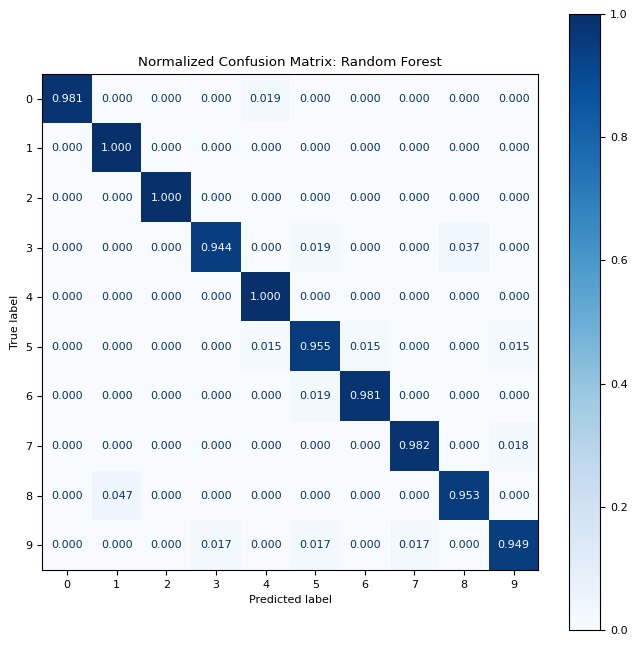

In [31]:
final_RF = RandomForestClassifier(n_estimators=320, max_depth=None, random_state=42, n_jobs=-1) # Copy ideal hyps
final_RF.fit(Xtrain, ytrain)

rf_preds = final_RF.predict(Xtest)
print(f"RF Error Rate: {np.sum(rf_preds != ytest) / np.size(ytest)}")

cm = confusion_matrix(ytest, rf_preds, normalize='true')
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(ytest))
disp.plot(cmap='Blues', ax=ax, values_format='.3f')
plt.title("Normalized Confusion Matrix: Random Forest")
plt.grid(False)
plt.show()